In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from datetime import datetime

from rnn_class.util import get_wikipedia_data
from rnn_class.brown import get_sentences_with_word2idx_limit_vocab, get_sentences_with_word2idx

def get_bigram_probs(sentences, V, start_idx, end_idx, smoothing=1):
  # structure of bigram probability matrix will be:
  # (last word, current word) --> probability
  # we will use add-1 smoothing
  # note: we'll always ignore this from the END token
  bigram_probs = np.ones((V, V)) * smoothing
  for sentence in sentences:
    for i in range(len(sentence)):
      
      if i == 0:
        # beginning word
        bigram_probs[start_idx, sentence[i]] += 1
      else:
        # middle word
        bigram_probs[sentence[i-1], sentence[i]] += 1

      # if we're at the final word
      # we update the bigram for last -> current
      # AND current -> END token
      if i == len(sentence) - 1:
        # final word
        bigram_probs[sentence[i], end_idx] += 1

  # normalize the counts along the rows to get probabilities
  bigram_probs /= bigram_probs.sum(axis=1, keepdims=True)
  return bigram_probs


def compare():
  # load in the data
  # note: sentences are already converted to sequences of word indexes
  # note: you can limit the vocab size if you run out of memory
  sentences, word2idx = get_sentences_with_word2idx_limit_vocab(2000)
  # sentences, word2idx = get_sentences_with_word2idx()

  # vocab size
  V = len(word2idx)
  print("Vocab size:", V)

  # we will also treat beginning of sentence and end of sentence as bigrams
  # START -> first word
  # last word -> END
  start_idx = word2idx['START']
  end_idx = word2idx['END']


  # a matrix where:
  # row = last word
  # col = current word
  # value at [row, col] = p(current word | last word)
  bigram_probs = get_bigram_probs(sentences, V, start_idx, end_idx, smoothing=0.1)


  # train a logistic model
  W = np.random.randn(V, V) / np.sqrt(V)

  losses = []
  epochs = 1
  lr = 1e-1
  
  def softmax(a):
    a = a - a.max()
    exp_a = np.exp(a)
    return exp_a / exp_a.sum(axis=1, keepdims=True)

  # what is the loss if we set W = log(bigram_probs)?
  W_bigram = np.log(bigram_probs)
  bigram_losses = []


  t0 = datetime.now()
  for epoch in range(epochs):
    # shuffle sentences at each epoch
    random.shuffle(sentences)

    j = 0 # keep track of iterations
    for sentence in sentences:
      # convert sentence into one-hot encoded inputs and targets
      sentence = [start_idx] + sentence + [end_idx]
      n = len(sentence)
      inputs = np.zeros((n - 1, V))
      targets = np.zeros((n - 1, V))
      inputs[np.arange(n - 1), sentence[:n-1]] = 1
      targets[np.arange(n - 1), sentence[1:]] = 1

      # get output predictions
      predictions = softmax(inputs.dot(W))

      # do a gradient descent step
      W = W - lr * inputs.T.dot(predictions - targets)

      # keep track of the loss, only for debugging purposes
      loss = -np.sum(targets * np.log(predictions)) / (n - 1)
      losses.append(loss)

      # keep track of the bigram loss
      # only do it for the first epoch to avoid redundancy 
      if epoch == 0:
        bigram_predictions = softmax(inputs.dot(W_bigram))
        bigram_loss = -np.sum(targets * np.log(bigram_predictions)) / (n - 1)
        bigram_losses.append(bigram_loss)


      if j % 10 == 0: #debuggin step to ensure cost is decreasing at every step
        print("epoch:", epoch, "sentence: %s/%s" % (j, len(sentences)), "loss:", loss)
      j += 1

  print("Elapsed time training:", datetime.now() - t0)
  plt.plot(losses)

  # plot a horizontal line for the bigram loss
  avg_bigram_loss = np.mean(bigram_losses)
  print("avg_bigram_loss:", avg_bigram_loss)
  plt.axhline(y=avg_bigram_loss, color='r', linestyle='-')


  # plot smoothed losses to reduce variability, each word can map to many other next words(large variance)
  def smoothed_loss(x, decay=0.99): #exponential smoothing
    y = np.zeros(len(x))
    last = 0
    for t in range(len(x)):
      z = decay * last + (1 - decay) * x[t]
      y[t] = z / (1 - decay ** (t + 1))
      last = z
    return y

  plt.plot(smoothed_loss(losses))
  plt.show()

  # plot W and bigram probs side-by-side
  # for the most common 200 words
  plt.subplot(1,2,1)
  plt.title("Logistic Model")
  plt.imshow(softmax(W))
  plt.subplot(1,2,2) 
  plt.title("Bigram Probs")
  plt.imshow(bigram_probs)
  plt.show()


START inf
END inf
man inf
paris inf
britain inf
england inf
king inf
woman inf
rome inf
london inf
queen inf
italy inf
france inf
the 69971
, 58334
. 49346
of 36412
and 28853
to 26158
a 23195
in 21337
that 10594
is 10109
was 9815
he 9548
for 9489
`` 8837
'' 8789
it 8760
with 7289
as 7253
his 6996
on 6741
be 6377
; 5566
at 5372
by 5306
i 5164
this 5145
had 5133
? 4693
not 4610
are 4394
but 4381
from 4370
or 4206
have 3942
an 3740
they 3620
which 3561
-- 3432
one 3292
you 3286
were 3284
her 3036
all 3001
she 2860
there 2728
would 2714
their 2669
we 2652
him 2619
been 2472
) 2466
has 2437
( 2435
when 2331
who 2252
will 2245
more 2215
if 2198
no 2139
out 2097
so 1985
said 1961
what 1908
up 1890
its 1858
about 1815
: 1795
into 1791
than 1790
them 1788
can 1772
only 1748
other 1702
new 1635
some 1618
could 1601
time 1598
! 1596
these 1573
two 1412
may 1402
then 1380
do 1363
first 1361
any 1344
my 1318
now 1314
such 1303
like 1292
our 1252
over 1236
me 1181
even 1170
most 1159
made 1125
also 

pool 111
hospital 110
corps 110
wish 110
lack 110
completely 110
heavy 110
waiting 110
speak 110
ball 110
standard 110
extent 110
visit 109
democratic 109
firm 109
income 109
ahead 109
deep 109
there's 109
language 109
principle 109
none 108
price 108
designed 108
indicated 108
analysis 108
distance 108
expect 108
established 108
products 108
effects 108
growing 108
importance 108
continue 107
serve 107
determine 107
cities 107
elements 107
negro 107
leaders 107
division 107
pretty 107
easily 107
existence 107
attitude 107
stress 107
8 106
afternoon 106
limited 106
hardly 106
agreement 106
factors 106
scene 106
remained 106
closed 106
write 106
applied 106
health 105
married 105
suggested 105
attack 105
rhode 105
interested 105
station 105
professional 105
won't 105
drive 105
season 105
reach 105
b 105
despite 104
current 104
spent 104
eight 104
covered 104
role 104
played 104
i'd 104
becomes 104
date 103
council 103
race 103
unit 103
commission 103
original 103
mouth 103
reasons 103
s

Vocab size: 2001
epoch: 0 sentence: 0/57013 loss: 7.600247716840277
epoch: 0 sentence: 10/57013 loss: 7.4895787682320965
epoch: 0 sentence: 20/57013 loss: 7.225805113830402
epoch: 0 sentence: 30/57013 loss: 7.422562361571799
epoch: 0 sentence: 40/57013 loss: 7.32166436175736
epoch: 0 sentence: 50/57013 loss: 7.3914441749552315
epoch: 0 sentence: 60/57013 loss: 6.640503467984349
epoch: 0 sentence: 70/57013 loss: 6.67183702863293
epoch: 0 sentence: 80/57013 loss: 6.126793413966766
epoch: 0 sentence: 90/57013 loss: 7.521304057102252
epoch: 0 sentence: 100/57013 loss: 7.081599816369862
epoch: 0 sentence: 110/57013 loss: 6.415282500663629
epoch: 0 sentence: 120/57013 loss: 6.906702208681905
epoch: 0 sentence: 130/57013 loss: 7.211213837199536
epoch: 0 sentence: 140/57013 loss: 6.578258645453917
epoch: 0 sentence: 150/57013 loss: 6.784853758387485
epoch: 0 sentence: 160/57013 loss: 6.697026839235947
epoch: 0 sentence: 170/57013 loss: 6.657369958169194
epoch: 0 sentence: 180/57013 loss: 7.026

epoch: 0 sentence: 1540/57013 loss: 3.228389081222549
epoch: 0 sentence: 1550/57013 loss: 6.35355832928876
epoch: 0 sentence: 1560/57013 loss: 6.154760641458618
epoch: 0 sentence: 1570/57013 loss: 5.917064882511417
epoch: 0 sentence: 1580/57013 loss: 5.75019256584941
epoch: 0 sentence: 1590/57013 loss: 6.599711076186404
epoch: 0 sentence: 1600/57013 loss: 5.987315030679151
epoch: 0 sentence: 1610/57013 loss: 5.379516459982047
epoch: 0 sentence: 1620/57013 loss: 5.379033092050798
epoch: 0 sentence: 1630/57013 loss: 5.071379950411363
epoch: 0 sentence: 1640/57013 loss: 6.343868728166381
epoch: 0 sentence: 1650/57013 loss: 5.2777415552560685
epoch: 0 sentence: 1660/57013 loss: 4.095378462106978
epoch: 0 sentence: 1670/57013 loss: 6.3249084967686064
epoch: 0 sentence: 1680/57013 loss: 5.4206095799542195
epoch: 0 sentence: 1690/57013 loss: 6.520423981339258
epoch: 0 sentence: 1700/57013 loss: 4.288124199405727
epoch: 0 sentence: 1710/57013 loss: 4.899172841252092
epoch: 0 sentence: 1720/570

epoch: 0 sentence: 3060/57013 loss: 5.223246195568564
epoch: 0 sentence: 3070/57013 loss: 6.700370321692595
epoch: 0 sentence: 3080/57013 loss: 5.506032720834441
epoch: 0 sentence: 3090/57013 loss: 5.741974173826053
epoch: 0 sentence: 3100/57013 loss: 5.682172004151397
epoch: 0 sentence: 3110/57013 loss: 6.519594312436155
epoch: 0 sentence: 3120/57013 loss: 3.6900013183811526
epoch: 0 sentence: 3130/57013 loss: 5.233014528490107
epoch: 0 sentence: 3140/57013 loss: 4.040480913258624
epoch: 0 sentence: 3150/57013 loss: 4.234871500284062
epoch: 0 sentence: 3160/57013 loss: 5.028903650013538
epoch: 0 sentence: 3170/57013 loss: 3.9881075743032133
epoch: 0 sentence: 3180/57013 loss: 5.492482441579105
epoch: 0 sentence: 3190/57013 loss: 5.170504121324684
epoch: 0 sentence: 3200/57013 loss: 6.203068855103379
epoch: 0 sentence: 3210/57013 loss: 4.774399629945078
epoch: 0 sentence: 3220/57013 loss: 5.93516085069682
epoch: 0 sentence: 3230/57013 loss: 5.722546907791779
epoch: 0 sentence: 3240/570

epoch: 0 sentence: 4580/57013 loss: 5.555512794493178
epoch: 0 sentence: 4590/57013 loss: 3.513325300627043
epoch: 0 sentence: 4600/57013 loss: 5.520174701619145
epoch: 0 sentence: 4610/57013 loss: 5.545551155336745
epoch: 0 sentence: 4620/57013 loss: 5.906434695287891
epoch: 0 sentence: 4630/57013 loss: 6.1710232706506885
epoch: 0 sentence: 4640/57013 loss: 4.2114071175387915
epoch: 0 sentence: 4650/57013 loss: 5.792679434296655
epoch: 0 sentence: 4660/57013 loss: 5.9217245387696735
epoch: 0 sentence: 4670/57013 loss: 4.882333778653282
epoch: 0 sentence: 4680/57013 loss: 5.551899895002254
epoch: 0 sentence: 4690/57013 loss: 4.037982201464142
epoch: 0 sentence: 4700/57013 loss: 5.212173893538402
epoch: 0 sentence: 4710/57013 loss: 5.413897763935241
epoch: 0 sentence: 4720/57013 loss: 5.8249471109465105
epoch: 0 sentence: 4730/57013 loss: 5.068833936680177
epoch: 0 sentence: 4740/57013 loss: 5.843856180313512
epoch: 0 sentence: 4750/57013 loss: 4.7873380061531305
epoch: 0 sentence: 4760

epoch: 0 sentence: 6100/57013 loss: 4.586300322560426
epoch: 0 sentence: 6110/57013 loss: 4.9356701316946205
epoch: 0 sentence: 6120/57013 loss: 3.6425407190402335
epoch: 0 sentence: 6130/57013 loss: 5.411066126832587
epoch: 0 sentence: 6140/57013 loss: 6.9172758396614835
epoch: 0 sentence: 6150/57013 loss: 3.8795998903144935
epoch: 0 sentence: 6160/57013 loss: 4.68922055455161
epoch: 0 sentence: 6170/57013 loss: 5.1460194844591705
epoch: 0 sentence: 6180/57013 loss: 4.737206181451082
epoch: 0 sentence: 6190/57013 loss: 4.491767600155944
epoch: 0 sentence: 6200/57013 loss: 3.6080314771221977
epoch: 0 sentence: 6210/57013 loss: 4.260377831698962
epoch: 0 sentence: 6220/57013 loss: 5.2249616705169375
epoch: 0 sentence: 6230/57013 loss: 2.9301250604953712
epoch: 0 sentence: 6240/57013 loss: 5.062354093698052
epoch: 0 sentence: 6250/57013 loss: 5.113531709377478
epoch: 0 sentence: 6260/57013 loss: 4.978687064794611
epoch: 0 sentence: 6270/57013 loss: 6.189443126918176
epoch: 0 sentence: 62

epoch: 0 sentence: 7620/57013 loss: 4.814774570287161
epoch: 0 sentence: 7630/57013 loss: 5.7563061597622145
epoch: 0 sentence: 7640/57013 loss: 5.473935112151628
epoch: 0 sentence: 7650/57013 loss: 3.3385858078706985
epoch: 0 sentence: 7660/57013 loss: 3.498640270404658
epoch: 0 sentence: 7670/57013 loss: 5.638733383751178
epoch: 0 sentence: 7680/57013 loss: 3.284673087747972
epoch: 0 sentence: 7690/57013 loss: 5.443352845972676
epoch: 0 sentence: 7700/57013 loss: 5.301348118801969
epoch: 0 sentence: 7710/57013 loss: 5.787422706996963
epoch: 0 sentence: 7720/57013 loss: 5.224277392275514
epoch: 0 sentence: 7730/57013 loss: 3.053480371678371
epoch: 0 sentence: 7740/57013 loss: 5.210621550083483
epoch: 0 sentence: 7750/57013 loss: 4.987360019547308
epoch: 0 sentence: 7760/57013 loss: 4.479885906467941
epoch: 0 sentence: 7770/57013 loss: 4.870374583187109
epoch: 0 sentence: 7780/57013 loss: 4.643801339682789
epoch: 0 sentence: 7790/57013 loss: 4.285315628427436
epoch: 0 sentence: 7800/57

epoch: 0 sentence: 9140/57013 loss: 6.512667273650591
epoch: 0 sentence: 9150/57013 loss: 5.825204097243233
epoch: 0 sentence: 9160/57013 loss: 6.439756474847309
epoch: 0 sentence: 9170/57013 loss: 5.121409481715691
epoch: 0 sentence: 9180/57013 loss: 4.97054061267307
epoch: 0 sentence: 9190/57013 loss: 5.130794021182749
epoch: 0 sentence: 9200/57013 loss: 3.24470911566164
epoch: 0 sentence: 9210/57013 loss: 4.585051625770785
epoch: 0 sentence: 9220/57013 loss: 5.299024357847118
epoch: 0 sentence: 9230/57013 loss: 4.4854312854228136
epoch: 0 sentence: 9240/57013 loss: 3.291184446100119
epoch: 0 sentence: 9250/57013 loss: 2.843152620800243
epoch: 0 sentence: 9260/57013 loss: 4.527899342515959
epoch: 0 sentence: 9270/57013 loss: 5.737991107884313
epoch: 0 sentence: 9280/57013 loss: 5.755225725737761
epoch: 0 sentence: 9290/57013 loss: 6.950338298413191
epoch: 0 sentence: 9300/57013 loss: 5.919668732553135
epoch: 0 sentence: 9310/57013 loss: 4.406973314273024
epoch: 0 sentence: 9320/57013

epoch: 0 sentence: 10650/57013 loss: 5.998278451308583
epoch: 0 sentence: 10660/57013 loss: 4.796125777154999
epoch: 0 sentence: 10670/57013 loss: 4.567527174857026
epoch: 0 sentence: 10680/57013 loss: 6.509392285262908
epoch: 0 sentence: 10690/57013 loss: 5.759315825943379
epoch: 0 sentence: 10700/57013 loss: 4.060861375826691
epoch: 0 sentence: 10710/57013 loss: 5.400899226688388
epoch: 0 sentence: 10720/57013 loss: 4.377074494919318
epoch: 0 sentence: 10730/57013 loss: 5.855450853731859
epoch: 0 sentence: 10740/57013 loss: 5.602402687880984
epoch: 0 sentence: 10750/57013 loss: 4.549388963883401
epoch: 0 sentence: 10760/57013 loss: 5.8974528581220556
epoch: 0 sentence: 10770/57013 loss: 3.954192789123011
epoch: 0 sentence: 10780/57013 loss: 5.624713326251899
epoch: 0 sentence: 10790/57013 loss: 5.530532642041958
epoch: 0 sentence: 10800/57013 loss: 4.3072082787124275
epoch: 0 sentence: 10810/57013 loss: 1.3647839879054697
epoch: 0 sentence: 10820/57013 loss: 4.5375905735062245
epoch:

epoch: 0 sentence: 12140/57013 loss: 6.049875067446026
epoch: 0 sentence: 12150/57013 loss: 4.783746658216903
epoch: 0 sentence: 12160/57013 loss: 4.804572732221038
epoch: 0 sentence: 12170/57013 loss: 4.780912177079084
epoch: 0 sentence: 12180/57013 loss: 4.456914115645572
epoch: 0 sentence: 12190/57013 loss: 5.036474997152022
epoch: 0 sentence: 12200/57013 loss: 3.958751939639888
epoch: 0 sentence: 12210/57013 loss: 5.065841379334891
epoch: 0 sentence: 12220/57013 loss: 5.320126527798311
epoch: 0 sentence: 12230/57013 loss: 5.5627938561448
epoch: 0 sentence: 12240/57013 loss: 5.780187037604159
epoch: 0 sentence: 12250/57013 loss: 5.565171361133141
epoch: 0 sentence: 12260/57013 loss: 4.677843556582556
epoch: 0 sentence: 12270/57013 loss: 3.6863119863310185
epoch: 0 sentence: 12280/57013 loss: 5.862405328417028
epoch: 0 sentence: 12290/57013 loss: 4.4621638344060255
epoch: 0 sentence: 12300/57013 loss: 4.848185287577732
epoch: 0 sentence: 12310/57013 loss: 5.334165395945201
epoch: 0 s

epoch: 0 sentence: 13630/57013 loss: 4.160467801708853
epoch: 0 sentence: 13640/57013 loss: 1.7480883860815895
epoch: 0 sentence: 13650/57013 loss: 4.525232243238368
epoch: 0 sentence: 13660/57013 loss: 4.593381415892429
epoch: 0 sentence: 13670/57013 loss: 4.842153853456222
epoch: 0 sentence: 13680/57013 loss: 2.512503613962185
epoch: 0 sentence: 13690/57013 loss: 5.3447436608560155
epoch: 0 sentence: 13700/57013 loss: 6.210688971222043
epoch: 0 sentence: 13710/57013 loss: 2.9993753337013356
epoch: 0 sentence: 13720/57013 loss: 3.5348324148228425
epoch: 0 sentence: 13730/57013 loss: 5.792755280656823
epoch: 0 sentence: 13740/57013 loss: 1.958161140449925
epoch: 0 sentence: 13750/57013 loss: 4.428416938646944
epoch: 0 sentence: 13760/57013 loss: 5.275064671691081
epoch: 0 sentence: 13770/57013 loss: 5.566428649256148
epoch: 0 sentence: 13780/57013 loss: 4.936493352356229
epoch: 0 sentence: 13790/57013 loss: 5.674789601118598
epoch: 0 sentence: 13800/57013 loss: 6.5973431235072875
epoch

epoch: 0 sentence: 15120/57013 loss: 5.188611430312049
epoch: 0 sentence: 15130/57013 loss: 5.779976397036731
epoch: 0 sentence: 15140/57013 loss: 5.415479933678307
epoch: 0 sentence: 15150/57013 loss: 4.335650080621039
epoch: 0 sentence: 15160/57013 loss: 5.497218621666543
epoch: 0 sentence: 15170/57013 loss: 4.951136457842308
epoch: 0 sentence: 15180/57013 loss: 3.9262788192574654
epoch: 0 sentence: 15190/57013 loss: 5.482280882695547
epoch: 0 sentence: 15200/57013 loss: 4.992372161792733
epoch: 0 sentence: 15210/57013 loss: 4.876846463467789
epoch: 0 sentence: 15220/57013 loss: 5.105500621769308
epoch: 0 sentence: 15230/57013 loss: 4.836926709144296
epoch: 0 sentence: 15240/57013 loss: 5.862035486480391
epoch: 0 sentence: 15250/57013 loss: 3.5383073170794637
epoch: 0 sentence: 15260/57013 loss: 1.9698537721442684
epoch: 0 sentence: 15270/57013 loss: 4.6302186447108555
epoch: 0 sentence: 15280/57013 loss: 3.1241633308302585
epoch: 0 sentence: 15290/57013 loss: 3.0263409010668663
epoc

epoch: 0 sentence: 16610/57013 loss: 5.6841120269216345
epoch: 0 sentence: 16620/57013 loss: 3.5692927987722918
epoch: 0 sentence: 16630/57013 loss: 5.646349568186068
epoch: 0 sentence: 16640/57013 loss: 8.063302573929434
epoch: 0 sentence: 16650/57013 loss: 4.7189578215527375
epoch: 0 sentence: 16660/57013 loss: 3.3307726384720446
epoch: 0 sentence: 16670/57013 loss: 4.81574318439402
epoch: 0 sentence: 16680/57013 loss: 3.4418438479442006
epoch: 0 sentence: 16690/57013 loss: 5.090573329055424
epoch: 0 sentence: 16700/57013 loss: 4.611695714539151
epoch: 0 sentence: 16710/57013 loss: 5.526506606405553
epoch: 0 sentence: 16720/57013 loss: 4.409210683539688
epoch: 0 sentence: 16730/57013 loss: 4.447893622433732
epoch: 0 sentence: 16740/57013 loss: 5.0562448882306885
epoch: 0 sentence: 16750/57013 loss: 4.20061672363342
epoch: 0 sentence: 16760/57013 loss: 5.4201030196245235
epoch: 0 sentence: 16770/57013 loss: 1.505228782305811
epoch: 0 sentence: 16780/57013 loss: 5.474377644715597
epoch

epoch: 0 sentence: 18100/57013 loss: 6.406218767192539
epoch: 0 sentence: 18110/57013 loss: 5.674222670782092
epoch: 0 sentence: 18120/57013 loss: 4.6691375533765065
epoch: 0 sentence: 18130/57013 loss: 3.6674518836726966
epoch: 0 sentence: 18140/57013 loss: 4.736558553052518
epoch: 0 sentence: 18150/57013 loss: 2.79330854613256
epoch: 0 sentence: 18160/57013 loss: 4.402732199291164
epoch: 0 sentence: 18170/57013 loss: 4.282680183890119
epoch: 0 sentence: 18180/57013 loss: 3.929184469425984
epoch: 0 sentence: 18190/57013 loss: 4.905168565359891
epoch: 0 sentence: 18200/57013 loss: 4.786486428851576
epoch: 0 sentence: 18210/57013 loss: 5.03636032148755
epoch: 0 sentence: 18220/57013 loss: 1.791697537834682
epoch: 0 sentence: 18230/57013 loss: 4.802119351283665
epoch: 0 sentence: 18240/57013 loss: 4.631910319384469
epoch: 0 sentence: 18250/57013 loss: 4.389603484392436
epoch: 0 sentence: 18260/57013 loss: 5.6455808104427945
epoch: 0 sentence: 18270/57013 loss: 5.435205282298183
epoch: 0 

epoch: 0 sentence: 19590/57013 loss: 2.812683937236839
epoch: 0 sentence: 19600/57013 loss: 4.619186702660895
epoch: 0 sentence: 19610/57013 loss: 4.588370123077249
epoch: 0 sentence: 19620/57013 loss: 5.153184297769687
epoch: 0 sentence: 19630/57013 loss: 5.572994861038225
epoch: 0 sentence: 19640/57013 loss: 4.246735429437126
epoch: 0 sentence: 19650/57013 loss: 5.0085547673759905
epoch: 0 sentence: 19660/57013 loss: 4.622125238725932
epoch: 0 sentence: 19670/57013 loss: 4.744746926109473
epoch: 0 sentence: 19680/57013 loss: 4.507883917165589
epoch: 0 sentence: 19690/57013 loss: 4.683544451246174
epoch: 0 sentence: 19700/57013 loss: 4.522857567158505
epoch: 0 sentence: 19710/57013 loss: 4.142562516367665
epoch: 0 sentence: 19720/57013 loss: 4.153744906815531
epoch: 0 sentence: 19730/57013 loss: 4.506121733848358
epoch: 0 sentence: 19740/57013 loss: 3.454070998041551
epoch: 0 sentence: 19750/57013 loss: 2.145230648913901
epoch: 0 sentence: 19760/57013 loss: 4.545471106342668
epoch: 0 

epoch: 0 sentence: 21080/57013 loss: 4.022451799899798
epoch: 0 sentence: 21090/57013 loss: 4.3838133711187375
epoch: 0 sentence: 21100/57013 loss: 3.922716990432502
epoch: 0 sentence: 21110/57013 loss: 3.213183658062359
epoch: 0 sentence: 21120/57013 loss: 4.704720743726032
epoch: 0 sentence: 21130/57013 loss: 5.667631337620327
epoch: 0 sentence: 21140/57013 loss: 5.25383221741285
epoch: 0 sentence: 21150/57013 loss: 4.0237262330834795
epoch: 0 sentence: 21160/57013 loss: 4.19384225780595
epoch: 0 sentence: 21170/57013 loss: 5.41839322789082
epoch: 0 sentence: 21180/57013 loss: 3.86551813660409
epoch: 0 sentence: 21190/57013 loss: 4.799626255806609
epoch: 0 sentence: 21200/57013 loss: 4.824634891751434
epoch: 0 sentence: 21210/57013 loss: 2.503360410709616
epoch: 0 sentence: 21220/57013 loss: 5.949273524661976
epoch: 0 sentence: 21230/57013 loss: 3.487057661870157
epoch: 0 sentence: 21240/57013 loss: 6.072305639166905
epoch: 0 sentence: 21250/57013 loss: 5.034102717086858
epoch: 0 sen

epoch: 0 sentence: 22570/57013 loss: 5.054833727409679
epoch: 0 sentence: 22580/57013 loss: 5.188416687811823
epoch: 0 sentence: 22590/57013 loss: 4.725126841374233
epoch: 0 sentence: 22600/57013 loss: 4.273705902245531
epoch: 0 sentence: 22610/57013 loss: 4.066767852277664
epoch: 0 sentence: 22620/57013 loss: 4.659659061832371
epoch: 0 sentence: 22630/57013 loss: 3.6717427607407487
epoch: 0 sentence: 22640/57013 loss: 4.920741222229323
epoch: 0 sentence: 22650/57013 loss: 5.31938035851672
epoch: 0 sentence: 22660/57013 loss: 5.31087526694012
epoch: 0 sentence: 22670/57013 loss: 4.513751591800361
epoch: 0 sentence: 22680/57013 loss: 6.294648778542436
epoch: 0 sentence: 22690/57013 loss: 4.920365585948086
epoch: 0 sentence: 22700/57013 loss: 4.776708059929832
epoch: 0 sentence: 22710/57013 loss: 5.237207070488083
epoch: 0 sentence: 22720/57013 loss: 4.737270186163087
epoch: 0 sentence: 22730/57013 loss: 4.525857388551845
epoch: 0 sentence: 22740/57013 loss: 2.8145607660254757
epoch: 0 s

epoch: 0 sentence: 24060/57013 loss: 2.9899742997544734
epoch: 0 sentence: 24070/57013 loss: 3.092887950863525
epoch: 0 sentence: 24080/57013 loss: 4.479677719000407
epoch: 0 sentence: 24090/57013 loss: 5.072354989593255
epoch: 0 sentence: 24100/57013 loss: 5.29358315896075
epoch: 0 sentence: 24110/57013 loss: 4.843085792375713
epoch: 0 sentence: 24120/57013 loss: 4.731326756298056
epoch: 0 sentence: 24130/57013 loss: 5.491943820326811
epoch: 0 sentence: 24140/57013 loss: 4.798899635957769
epoch: 0 sentence: 24150/57013 loss: 5.2307559656167655
epoch: 0 sentence: 24160/57013 loss: 5.828401765813712
epoch: 0 sentence: 24170/57013 loss: 2.5261623614437756
epoch: 0 sentence: 24180/57013 loss: 5.144167396599955
epoch: 0 sentence: 24190/57013 loss: 5.460168104505755
epoch: 0 sentence: 24200/57013 loss: 5.918474281859324
epoch: 0 sentence: 24210/57013 loss: 2.8231500749975953
epoch: 0 sentence: 24220/57013 loss: 5.426684361287784
epoch: 0 sentence: 24230/57013 loss: 5.442051819633989
epoch: 

epoch: 0 sentence: 25550/57013 loss: 4.752988887255693
epoch: 0 sentence: 25560/57013 loss: 5.0609135375011
epoch: 0 sentence: 25570/57013 loss: 3.975577445156149
epoch: 0 sentence: 25580/57013 loss: 5.02379085719084
epoch: 0 sentence: 25590/57013 loss: 5.524578414481022
epoch: 0 sentence: 25600/57013 loss: 3.0132232169384947
epoch: 0 sentence: 25610/57013 loss: 5.536574718497528
epoch: 0 sentence: 25620/57013 loss: 4.572784721561208
epoch: 0 sentence: 25630/57013 loss: 4.23866679625602
epoch: 0 sentence: 25640/57013 loss: 3.6932493697841764
epoch: 0 sentence: 25650/57013 loss: 5.69263626313886
epoch: 0 sentence: 25660/57013 loss: 4.7969792977538654
epoch: 0 sentence: 25670/57013 loss: 3.2537155985407096
epoch: 0 sentence: 25680/57013 loss: 4.882384580292838
epoch: 0 sentence: 25690/57013 loss: 4.883449502579588
epoch: 0 sentence: 25700/57013 loss: 4.63320137729866
epoch: 0 sentence: 25710/57013 loss: 4.349936904855342
epoch: 0 sentence: 25720/57013 loss: 4.704675798767226
epoch: 0 sen

epoch: 0 sentence: 27040/57013 loss: 5.968052151255856
epoch: 0 sentence: 27050/57013 loss: 4.398674035116449
epoch: 0 sentence: 27060/57013 loss: 3.685086726046953
epoch: 0 sentence: 27070/57013 loss: 5.021634816755305
epoch: 0 sentence: 27080/57013 loss: 5.5100196824455745
epoch: 0 sentence: 27090/57013 loss: 4.2654660815152905
epoch: 0 sentence: 27100/57013 loss: 4.52700898839462
epoch: 0 sentence: 27110/57013 loss: 4.419688012501716
epoch: 0 sentence: 27120/57013 loss: 5.103565267973537
epoch: 0 sentence: 27130/57013 loss: 4.950102950586124
epoch: 0 sentence: 27140/57013 loss: 4.4144828080448875
epoch: 0 sentence: 27150/57013 loss: 6.2941053439067565
epoch: 0 sentence: 27160/57013 loss: 4.382255828652392
epoch: 0 sentence: 27170/57013 loss: 4.50090888348729
epoch: 0 sentence: 27180/57013 loss: 4.977755116857638
epoch: 0 sentence: 27190/57013 loss: 4.353111615878522
epoch: 0 sentence: 27200/57013 loss: 5.724456770991845
epoch: 0 sentence: 27210/57013 loss: 5.727042099668863
epoch: 0

epoch: 0 sentence: 28530/57013 loss: 1.6814371148196983
epoch: 0 sentence: 28540/57013 loss: 4.40355782165368
epoch: 0 sentence: 28550/57013 loss: 6.064075726317735
epoch: 0 sentence: 28560/57013 loss: 5.593507901672626
epoch: 0 sentence: 28570/57013 loss: 4.837480890567289
epoch: 0 sentence: 28580/57013 loss: 5.118420607267145
epoch: 0 sentence: 28590/57013 loss: 4.84762873626254
epoch: 0 sentence: 28600/57013 loss: 4.268528640882815
epoch: 0 sentence: 28610/57013 loss: 4.752674964458456
epoch: 0 sentence: 28620/57013 loss: 4.546028062573106
epoch: 0 sentence: 28630/57013 loss: 5.410876146017076
epoch: 0 sentence: 28640/57013 loss: 3.8750498974419596
epoch: 0 sentence: 28650/57013 loss: 3.6788552795708562
epoch: 0 sentence: 28660/57013 loss: 5.274684254754802
epoch: 0 sentence: 28670/57013 loss: 3.942550990527857
epoch: 0 sentence: 28680/57013 loss: 4.779621616328585
epoch: 0 sentence: 28690/57013 loss: 3.2572933484468543
epoch: 0 sentence: 28700/57013 loss: 4.712846135678549
epoch: 0

epoch: 0 sentence: 30020/57013 loss: 4.704760279015534
epoch: 0 sentence: 30030/57013 loss: 5.7149581491238655
epoch: 0 sentence: 30040/57013 loss: 5.322781068148929
epoch: 0 sentence: 30050/57013 loss: 5.009670195741701
epoch: 0 sentence: 30060/57013 loss: 5.939814672137161
epoch: 0 sentence: 30070/57013 loss: 5.594507663816637
epoch: 0 sentence: 30080/57013 loss: 3.9527133620148116
epoch: 0 sentence: 30090/57013 loss: 5.307460119684563
epoch: 0 sentence: 30100/57013 loss: 4.965651501454083
epoch: 0 sentence: 30110/57013 loss: 3.6772601258034503
epoch: 0 sentence: 30120/57013 loss: 5.0836160430814195
epoch: 0 sentence: 30130/57013 loss: 5.400384652237049
epoch: 0 sentence: 30140/57013 loss: 2.7020570413370053
epoch: 0 sentence: 30150/57013 loss: 4.430227870840458
epoch: 0 sentence: 30160/57013 loss: 5.5297165157999215
epoch: 0 sentence: 30170/57013 loss: 4.551571020743815
epoch: 0 sentence: 30180/57013 loss: 4.530417631654656
epoch: 0 sentence: 30190/57013 loss: 5.217812027663454
epoc

epoch: 0 sentence: 31510/57013 loss: 4.246770401174133
epoch: 0 sentence: 31520/57013 loss: 3.670762378230858
epoch: 0 sentence: 31530/57013 loss: 4.431166107189325
epoch: 0 sentence: 31540/57013 loss: 4.444358173054343
epoch: 0 sentence: 31550/57013 loss: 5.449979232604027
epoch: 0 sentence: 31560/57013 loss: 5.831788093730161
epoch: 0 sentence: 31570/57013 loss: 3.2665291204024416
epoch: 0 sentence: 31580/57013 loss: 4.83739648274651
epoch: 0 sentence: 31590/57013 loss: 4.94984310781838
epoch: 0 sentence: 31600/57013 loss: 5.408032259896641
epoch: 0 sentence: 31610/57013 loss: 5.11526127101554
epoch: 0 sentence: 31620/57013 loss: 5.164000939654508
epoch: 0 sentence: 31630/57013 loss: 5.3674670121630195
epoch: 0 sentence: 31640/57013 loss: 4.157018218437018
epoch: 0 sentence: 31650/57013 loss: 2.4334023651624084
epoch: 0 sentence: 31660/57013 loss: 4.749151254954071
epoch: 0 sentence: 31670/57013 loss: 3.2765303594777864
epoch: 0 sentence: 31680/57013 loss: 3.4524057936380834
epoch: 0

epoch: 0 sentence: 33000/57013 loss: 2.840587659532239
epoch: 0 sentence: 33010/57013 loss: 5.93831869389203
epoch: 0 sentence: 33020/57013 loss: 5.823513105849971
epoch: 0 sentence: 33030/57013 loss: 5.233393837064352
epoch: 0 sentence: 33040/57013 loss: 5.060135131145967
epoch: 0 sentence: 33050/57013 loss: 5.088580710075906
epoch: 0 sentence: 33060/57013 loss: 4.370888639436939
epoch: 0 sentence: 33070/57013 loss: 4.467329784845319
epoch: 0 sentence: 33080/57013 loss: 6.354054167148079
epoch: 0 sentence: 33090/57013 loss: 5.1277173539834005
epoch: 0 sentence: 33100/57013 loss: 5.588325977981648
epoch: 0 sentence: 33110/57013 loss: 4.754408206942157
epoch: 0 sentence: 33120/57013 loss: 4.932353579734477
epoch: 0 sentence: 33130/57013 loss: 4.856201633671385
epoch: 0 sentence: 33140/57013 loss: 6.359227616472261
epoch: 0 sentence: 33150/57013 loss: 3.9289903052081088
epoch: 0 sentence: 33160/57013 loss: 4.800997466050311
epoch: 0 sentence: 33170/57013 loss: 3.91264242597434
epoch: 0 s

epoch: 0 sentence: 34490/57013 loss: 4.37941534247265
epoch: 0 sentence: 34500/57013 loss: 4.3155908652185095
epoch: 0 sentence: 34510/57013 loss: 3.137097790228758
epoch: 0 sentence: 34520/57013 loss: 5.441537319750105
epoch: 0 sentence: 34530/57013 loss: 5.657291732461
epoch: 0 sentence: 34540/57013 loss: 3.2819581922398475
epoch: 0 sentence: 34550/57013 loss: 3.665596757810929
epoch: 0 sentence: 34560/57013 loss: 4.0736188467620185
epoch: 0 sentence: 34570/57013 loss: 4.371548946487105
epoch: 0 sentence: 34580/57013 loss: 3.5344342200673564
epoch: 0 sentence: 34590/57013 loss: 4.46982962450783
epoch: 0 sentence: 34600/57013 loss: 4.6063603641300235
epoch: 0 sentence: 34610/57013 loss: 2.147947253872571
epoch: 0 sentence: 34620/57013 loss: 5.057392890983079
epoch: 0 sentence: 34630/57013 loss: 3.7607963269265583
epoch: 0 sentence: 34640/57013 loss: 4.518327881348673
epoch: 0 sentence: 34650/57013 loss: 3.3121097120004626
epoch: 0 sentence: 34660/57013 loss: 5.611445983813669
epoch: 0

epoch: 0 sentence: 35980/57013 loss: 4.42572063418149
epoch: 0 sentence: 35990/57013 loss: 4.488670185749345
epoch: 0 sentence: 36000/57013 loss: 3.4393921184102574
epoch: 0 sentence: 36010/57013 loss: 3.4649846291428688
epoch: 0 sentence: 36020/57013 loss: 2.8263959056376766
epoch: 0 sentence: 36030/57013 loss: 4.255131201160477
epoch: 0 sentence: 36040/57013 loss: 4.2236898531201605
epoch: 0 sentence: 36050/57013 loss: 5.643211875195332
epoch: 0 sentence: 36060/57013 loss: 4.821193959844334
epoch: 0 sentence: 36070/57013 loss: 4.268466279803932
epoch: 0 sentence: 36080/57013 loss: 5.051522938597074
epoch: 0 sentence: 36090/57013 loss: 6.32592348568391
epoch: 0 sentence: 36100/57013 loss: 5.74874666876802
epoch: 0 sentence: 36110/57013 loss: 4.25765486712803
epoch: 0 sentence: 36120/57013 loss: 3.068161184339188
epoch: 0 sentence: 36130/57013 loss: 4.958562976074331
epoch: 0 sentence: 36140/57013 loss: 4.570052472677657
epoch: 0 sentence: 36150/57013 loss: 4.810193417837528
epoch: 0 s

epoch: 0 sentence: 37470/57013 loss: 5.48896737508947
epoch: 0 sentence: 37480/57013 loss: 4.724762095256164
epoch: 0 sentence: 37490/57013 loss: 3.6722723218834163
epoch: 0 sentence: 37500/57013 loss: 5.072426622059078
epoch: 0 sentence: 37510/57013 loss: 5.460660912151191
epoch: 0 sentence: 37520/57013 loss: 4.834692283418367
epoch: 0 sentence: 37530/57013 loss: 4.960995864903863
epoch: 0 sentence: 37540/57013 loss: 5.032783969951356
epoch: 0 sentence: 37550/57013 loss: 4.9153921362992
epoch: 0 sentence: 37560/57013 loss: 4.106593258887056
epoch: 0 sentence: 37570/57013 loss: 3.088845373317431
epoch: 0 sentence: 37580/57013 loss: 4.520464540622151
epoch: 0 sentence: 37590/57013 loss: 3.473204641137291
epoch: 0 sentence: 37600/57013 loss: 4.449190134322621
epoch: 0 sentence: 37610/57013 loss: 4.876962844782583
epoch: 0 sentence: 37620/57013 loss: 5.267650606875053
epoch: 0 sentence: 37630/57013 loss: 4.727667651828338
epoch: 0 sentence: 37640/57013 loss: 5.063707752722557
epoch: 0 sen

epoch: 0 sentence: 38960/57013 loss: 4.514002293800663
epoch: 0 sentence: 38970/57013 loss: 4.067576134598837
epoch: 0 sentence: 38980/57013 loss: 5.137136806672448
epoch: 0 sentence: 38990/57013 loss: 5.226486019004459
epoch: 0 sentence: 39000/57013 loss: 3.4440957325140515
epoch: 0 sentence: 39010/57013 loss: 2.189884521392609
epoch: 0 sentence: 39020/57013 loss: 4.863391896191458
epoch: 0 sentence: 39030/57013 loss: 3.332468844287863
epoch: 0 sentence: 39040/57013 loss: 4.686168588646875
epoch: 0 sentence: 39050/57013 loss: 2.2969636046835036
epoch: 0 sentence: 39060/57013 loss: 3.550590746766996
epoch: 0 sentence: 39070/57013 loss: 3.9968395946177218
epoch: 0 sentence: 39080/57013 loss: 4.794345102471718
epoch: 0 sentence: 39090/57013 loss: 4.822523734303954
epoch: 0 sentence: 39100/57013 loss: 4.545890845723822
epoch: 0 sentence: 39110/57013 loss: 3.41119405522191
epoch: 0 sentence: 39120/57013 loss: 4.075160520782837
epoch: 0 sentence: 39130/57013 loss: 5.595898245926075
epoch: 0

epoch: 0 sentence: 40450/57013 loss: 6.664864283717236
epoch: 0 sentence: 40460/57013 loss: 5.94143872592039
epoch: 0 sentence: 40470/57013 loss: 4.866846437231982
epoch: 0 sentence: 40480/57013 loss: 5.94553750075292
epoch: 0 sentence: 40490/57013 loss: 5.15584863754569
epoch: 0 sentence: 40500/57013 loss: 4.115145246833902
epoch: 0 sentence: 40510/57013 loss: 4.274326687283696
epoch: 0 sentence: 40520/57013 loss: 5.8236558472984825
epoch: 0 sentence: 40530/57013 loss: 4.412324456780998
epoch: 0 sentence: 40540/57013 loss: 5.117634312215336
epoch: 0 sentence: 40550/57013 loss: 5.922073119675183
epoch: 0 sentence: 40560/57013 loss: 5.120962752839618
epoch: 0 sentence: 40570/57013 loss: 2.280696056465394
epoch: 0 sentence: 40580/57013 loss: 5.689426287605241
epoch: 0 sentence: 40590/57013 loss: 5.622392336881809
epoch: 0 sentence: 40600/57013 loss: 4.248383316568829
epoch: 0 sentence: 40610/57013 loss: 4.145345293938517
epoch: 0 sentence: 40620/57013 loss: 4.208505006457442
epoch: 0 sen

epoch: 0 sentence: 41940/57013 loss: 3.131022517440688
epoch: 0 sentence: 41950/57013 loss: 4.710169725210481
epoch: 0 sentence: 41960/57013 loss: 4.327966916947069
epoch: 0 sentence: 41970/57013 loss: 4.377140294440923
epoch: 0 sentence: 41980/57013 loss: 2.959843316217948
epoch: 0 sentence: 41990/57013 loss: 5.594324496699926
epoch: 0 sentence: 42000/57013 loss: 4.237340996950212
epoch: 0 sentence: 42010/57013 loss: 4.771274100416371
epoch: 0 sentence: 42020/57013 loss: 2.723531372101974
epoch: 0 sentence: 42030/57013 loss: 3.5381423712377025
epoch: 0 sentence: 42040/57013 loss: 3.9225784182040577
epoch: 0 sentence: 42050/57013 loss: 4.157173868474018
epoch: 0 sentence: 42060/57013 loss: 5.6364886092793824
epoch: 0 sentence: 42070/57013 loss: 3.782345904852362
epoch: 0 sentence: 42080/57013 loss: 4.567790810548942
epoch: 0 sentence: 42090/57013 loss: 5.079476912502426
epoch: 0 sentence: 42100/57013 loss: 3.50676477000128
epoch: 0 sentence: 42110/57013 loss: 5.631377527862512
epoch: 0

epoch: 0 sentence: 43430/57013 loss: 5.068652156603624
epoch: 0 sentence: 43440/57013 loss: 4.697419872337304
epoch: 0 sentence: 43450/57013 loss: 4.7745782002439485
epoch: 0 sentence: 43460/57013 loss: 5.06292610371925
epoch: 0 sentence: 43470/57013 loss: 5.068675413651934
epoch: 0 sentence: 43480/57013 loss: 5.2014181243058335
epoch: 0 sentence: 43490/57013 loss: 3.4559869793925166
epoch: 0 sentence: 43500/57013 loss: 5.346140375381001
epoch: 0 sentence: 43510/57013 loss: 3.964521404744827
epoch: 0 sentence: 43520/57013 loss: 4.933626335795208
epoch: 0 sentence: 43530/57013 loss: 4.364336997734362
epoch: 0 sentence: 43540/57013 loss: 1.688720699599829
epoch: 0 sentence: 43550/57013 loss: 5.888900542767803
epoch: 0 sentence: 43560/57013 loss: 4.842745115001128
epoch: 0 sentence: 43570/57013 loss: 5.183437999820973
epoch: 0 sentence: 43580/57013 loss: 5.03629821474991
epoch: 0 sentence: 43590/57013 loss: 4.335388965200393
epoch: 0 sentence: 43600/57013 loss: 4.59376822997416
epoch: 0 s

epoch: 0 sentence: 44920/57013 loss: 5.009517975118027
epoch: 0 sentence: 44930/57013 loss: 4.3801861100704205
epoch: 0 sentence: 44940/57013 loss: 4.273385185449313
epoch: 0 sentence: 44950/57013 loss: 3.778563721949656
epoch: 0 sentence: 44960/57013 loss: 5.453669118086064
epoch: 0 sentence: 44970/57013 loss: 4.87205520878669
epoch: 0 sentence: 44980/57013 loss: 3.962065295237122
epoch: 0 sentence: 44990/57013 loss: 4.400211692179778
epoch: 0 sentence: 45000/57013 loss: 3.8574606647609926
epoch: 0 sentence: 45010/57013 loss: 5.146884299888
epoch: 0 sentence: 45020/57013 loss: 4.933036729068454
epoch: 0 sentence: 45030/57013 loss: 4.121296568777824
epoch: 0 sentence: 45040/57013 loss: 4.594830559139268
epoch: 0 sentence: 45050/57013 loss: 3.919101401724257
epoch: 0 sentence: 45060/57013 loss: 3.7097012279639943
epoch: 0 sentence: 45070/57013 loss: 5.606075104967885
epoch: 0 sentence: 45080/57013 loss: 4.289304695877545
epoch: 0 sentence: 45090/57013 loss: 6.883804758426577
epoch: 0 se

epoch: 0 sentence: 46410/57013 loss: 4.682081678894225
epoch: 0 sentence: 46420/57013 loss: 3.112101767709218
epoch: 0 sentence: 46430/57013 loss: 4.870955423244478
epoch: 0 sentence: 46440/57013 loss: 5.0969972001312875
epoch: 0 sentence: 46450/57013 loss: 4.854642311382521
epoch: 0 sentence: 46460/57013 loss: 4.927166160930259
epoch: 0 sentence: 46470/57013 loss: 5.463845417628871
epoch: 0 sentence: 46480/57013 loss: 2.130639909567728
epoch: 0 sentence: 46490/57013 loss: 5.401830357662086
epoch: 0 sentence: 46500/57013 loss: 3.4360073543766934
epoch: 0 sentence: 46510/57013 loss: 4.396511009448221
epoch: 0 sentence: 46520/57013 loss: 4.160224181952691
epoch: 0 sentence: 46530/57013 loss: 3.8566838478309005
epoch: 0 sentence: 46540/57013 loss: 3.2423015538858686
epoch: 0 sentence: 46550/57013 loss: 4.848641617520417
epoch: 0 sentence: 46560/57013 loss: 5.036187549513112
epoch: 0 sentence: 46570/57013 loss: 3.532708742976795
epoch: 0 sentence: 46580/57013 loss: 5.003011103352373
epoch:

epoch: 0 sentence: 47900/57013 loss: 5.138373804360137
epoch: 0 sentence: 47910/57013 loss: 3.5541317357375974
epoch: 0 sentence: 47920/57013 loss: 3.8757701756966654
epoch: 0 sentence: 47930/57013 loss: 5.6220297189215405
epoch: 0 sentence: 47940/57013 loss: 3.5576775780418624
epoch: 0 sentence: 47950/57013 loss: 6.05625895374824
epoch: 0 sentence: 47960/57013 loss: 5.0976093851101085
epoch: 0 sentence: 47970/57013 loss: 4.1518973764300595
epoch: 0 sentence: 47980/57013 loss: 4.1545130381753275
epoch: 0 sentence: 47990/57013 loss: 4.4009529785633985
epoch: 0 sentence: 48000/57013 loss: 4.000017264445676
epoch: 0 sentence: 48010/57013 loss: 6.019717834939153
epoch: 0 sentence: 48020/57013 loss: 4.476110516008575
epoch: 0 sentence: 48030/57013 loss: 5.079869030723146
epoch: 0 sentence: 48040/57013 loss: 4.193068667451807
epoch: 0 sentence: 48050/57013 loss: 5.237313580869498
epoch: 0 sentence: 48060/57013 loss: 4.2951628469728265
epoch: 0 sentence: 48070/57013 loss: 4.825625309061508
ep

epoch: 0 sentence: 49390/57013 loss: 4.137106936431468
epoch: 0 sentence: 49400/57013 loss: 4.207713187760417
epoch: 0 sentence: 49410/57013 loss: 4.699321105295269
epoch: 0 sentence: 49420/57013 loss: 3.4150749809611205
epoch: 0 sentence: 49430/57013 loss: 5.497063158847887
epoch: 0 sentence: 49440/57013 loss: 5.367602776328862
epoch: 0 sentence: 49450/57013 loss: 3.5986172476317657
epoch: 0 sentence: 49460/57013 loss: 5.226244046534925
epoch: 0 sentence: 49470/57013 loss: 4.18659207630314
epoch: 0 sentence: 49480/57013 loss: 4.290382932301629
epoch: 0 sentence: 49490/57013 loss: 4.621230155509684
epoch: 0 sentence: 49500/57013 loss: 5.211941496319614
epoch: 0 sentence: 49510/57013 loss: 4.744592886438123
epoch: 0 sentence: 49520/57013 loss: 4.514986893953849
epoch: 0 sentence: 49530/57013 loss: 4.99881061679305
epoch: 0 sentence: 49540/57013 loss: 4.600920439745027
epoch: 0 sentence: 49550/57013 loss: 5.367161362732978
epoch: 0 sentence: 49560/57013 loss: 4.344053486910753
epoch: 0 s

epoch: 0 sentence: 50880/57013 loss: 3.6590429677884533
epoch: 0 sentence: 50890/57013 loss: 4.836425632499947
epoch: 0 sentence: 50900/57013 loss: 4.8108772722817905
epoch: 0 sentence: 50910/57013 loss: 3.484893136273169
epoch: 0 sentence: 50920/57013 loss: 4.1643169357581185
epoch: 0 sentence: 50930/57013 loss: 4.749633618675714
epoch: 0 sentence: 50940/57013 loss: 4.5784101749701085
epoch: 0 sentence: 50950/57013 loss: 4.727861993813663
epoch: 0 sentence: 50960/57013 loss: 3.7082977319940196
epoch: 0 sentence: 50970/57013 loss: 3.660904430650452
epoch: 0 sentence: 50980/57013 loss: 4.182312993592339
epoch: 0 sentence: 50990/57013 loss: 3.271095913548139
epoch: 0 sentence: 51000/57013 loss: 3.644928533081572
epoch: 0 sentence: 51010/57013 loss: 4.430191241901555
epoch: 0 sentence: 51020/57013 loss: 4.607645197255135
epoch: 0 sentence: 51030/57013 loss: 4.556334389114066
epoch: 0 sentence: 51040/57013 loss: 5.284680886886132
epoch: 0 sentence: 51050/57013 loss: 5.45583540697692
epoch:

epoch: 0 sentence: 52370/57013 loss: 2.8801232739210127
epoch: 0 sentence: 52380/57013 loss: 4.062298933094502
epoch: 0 sentence: 52390/57013 loss: 3.218973470973506
epoch: 0 sentence: 52400/57013 loss: 5.4528596175029165
epoch: 0 sentence: 52410/57013 loss: 3.4957852585308387
epoch: 0 sentence: 52420/57013 loss: 4.883111302959
epoch: 0 sentence: 52430/57013 loss: 4.1649877806610585
epoch: 0 sentence: 52440/57013 loss: 4.991611630737854
epoch: 0 sentence: 52450/57013 loss: 4.367899906144342
epoch: 0 sentence: 52460/57013 loss: 5.2731900538940994
epoch: 0 sentence: 52470/57013 loss: 4.323747542680571
epoch: 0 sentence: 52480/57013 loss: 4.650080542994925
epoch: 0 sentence: 52490/57013 loss: 4.2073648967908515
epoch: 0 sentence: 52500/57013 loss: 3.7076251485299103
epoch: 0 sentence: 52510/57013 loss: 4.3353420149737
epoch: 0 sentence: 52520/57013 loss: 4.140518149500955
epoch: 0 sentence: 52530/57013 loss: 5.00980604161056
epoch: 0 sentence: 52540/57013 loss: 2.802168699977983
epoch: 0 

epoch: 0 sentence: 53860/57013 loss: 4.365730867559361
epoch: 0 sentence: 53870/57013 loss: 4.657068898646053
epoch: 0 sentence: 53880/57013 loss: 5.360822356638262
epoch: 0 sentence: 53890/57013 loss: 3.8006015797403316
epoch: 0 sentence: 53900/57013 loss: 4.788428977982925
epoch: 0 sentence: 53910/57013 loss: 4.277268241709683
epoch: 0 sentence: 53920/57013 loss: 4.698403921072694
epoch: 0 sentence: 53930/57013 loss: 4.101744278089016
epoch: 0 sentence: 53940/57013 loss: 4.851788085667516
epoch: 0 sentence: 53950/57013 loss: 4.397079431379661
epoch: 0 sentence: 53960/57013 loss: 3.6097095805503647
epoch: 0 sentence: 53970/57013 loss: 5.24511835347866
epoch: 0 sentence: 53980/57013 loss: 4.17880706964829
epoch: 0 sentence: 53990/57013 loss: 3.6555205185922337
epoch: 0 sentence: 54000/57013 loss: 4.604986278866649
epoch: 0 sentence: 54010/57013 loss: 3.7482325669304397
epoch: 0 sentence: 54020/57013 loss: 3.6737350983259476
epoch: 0 sentence: 54030/57013 loss: 4.236052553826592
epoch: 

epoch: 0 sentence: 55350/57013 loss: 5.128282824995325
epoch: 0 sentence: 55360/57013 loss: 7.429837496645396
epoch: 0 sentence: 55370/57013 loss: 5.124872873508409
epoch: 0 sentence: 55380/57013 loss: 4.716474560087566
epoch: 0 sentence: 55390/57013 loss: 5.043903607774408
epoch: 0 sentence: 55400/57013 loss: 4.100543746024006
epoch: 0 sentence: 55410/57013 loss: 4.080723923615593
epoch: 0 sentence: 55420/57013 loss: 3.040516260056724
epoch: 0 sentence: 55430/57013 loss: 4.494578163558294
epoch: 0 sentence: 55440/57013 loss: 5.754035470084941
epoch: 0 sentence: 55450/57013 loss: 4.721321233869793
epoch: 0 sentence: 55460/57013 loss: 5.76482953892641
epoch: 0 sentence: 55470/57013 loss: 4.314889642370571
epoch: 0 sentence: 55480/57013 loss: 4.625672756715897
epoch: 0 sentence: 55490/57013 loss: 4.733081761553174
epoch: 0 sentence: 55500/57013 loss: 5.873632496111261
epoch: 0 sentence: 55510/57013 loss: 3.8253725748737186
epoch: 0 sentence: 55520/57013 loss: 4.602322092033754
epoch: 0 s

epoch: 0 sentence: 56840/57013 loss: 8.097141565291603
epoch: 0 sentence: 56850/57013 loss: 4.150589829592246
epoch: 0 sentence: 56860/57013 loss: 4.247520468103011
epoch: 0 sentence: 56870/57013 loss: 4.603943354175532
epoch: 0 sentence: 56880/57013 loss: 4.092121750905683
epoch: 0 sentence: 56890/57013 loss: 3.7208985666962335
epoch: 0 sentence: 56900/57013 loss: 4.416335667570519
epoch: 0 sentence: 56910/57013 loss: 4.529753570171348
epoch: 0 sentence: 56920/57013 loss: 4.860028644701521
epoch: 0 sentence: 56930/57013 loss: 3.916201010062491
epoch: 0 sentence: 56940/57013 loss: 4.065036810529405
epoch: 0 sentence: 56950/57013 loss: 3.1114032729453562
epoch: 0 sentence: 56960/57013 loss: 5.81666786378173
epoch: 0 sentence: 56970/57013 loss: 4.674339034572956
epoch: 0 sentence: 56980/57013 loss: 5.859777328645348
epoch: 0 sentence: 56990/57013 loss: 3.2599218826966023
epoch: 0 sentence: 57000/57013 loss: 4.484032424030045
epoch: 0 sentence: 57010/57013 loss: 5.463509733983726
Elapsed 

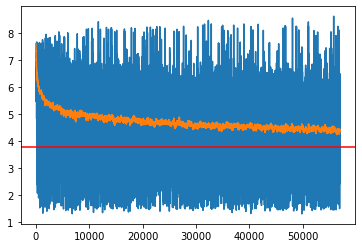

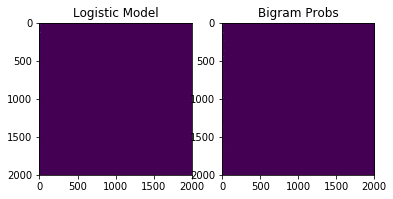

In [3]:
compare()